##SVM
Importing all relevant libraries for Data Preparation (importing and cleaning), EDA, ML Model Implementation and Results Evaluation.

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import pandas as pd
import numpy as np
#import tools as t
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
sns.set()
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
%load_ext autoreload 
%autoreload 2

Firstly, we read the dataset into a dataframe using pandas.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Code1/Dataset_final.xlsx")
df.tail()

,user_id_session_date,application_count,application_nunique,category_nunique,battery_delta_sum,amount_session,notification,ratio_notification_opened_session,duration_seconds,night,morning,midday,evening,binary_labels,scores
2232,10947T43540,5,3,2,0,1,0,0.000000,1360.000000,0.000000,0.000000,0.000000,100.000000,0,1.0
2233,10947T43541,62,11,6,9,23,12,0.521739,5461.000000,0.000000,0.000000,59.677419,40.322581,0,1.0
2234,10947T43543,84,8,5,37,2,0,0.000000,5815.000003,0.000000,0.000000,15.476190,84.523810,1,2.0
2235,10947T43544,13,9,6,90,1,0,0.000000,1642.000000,15.384615,7.692308,12.820513,64.102564,0,1.5
2236,10947T43545,61,10,7,58,10,4,0.400000,5051.000001,27.868852,31.147541,0.000000,40.983607,1,2.0


In [0]:
print (df['binary_labels'].value_counts())

0    1385
1     852
Name: binary_labels, dtype: int64


Our dataset is imbalanced ('0' = 1385, '1' = 852) which means data sampling and evaluation must be done carefully.

A concise summary of the dataframe is given below. It shows that there a total of 14 non-null columns. 

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 14 columns):
user_id_session_date                 2237 non-null object
application_count                    2237 non-null int64
application_nunique                  2237 non-null int64
category_nunique                     2237 non-null int64
battery_delta_sum                    2237 non-null int64
amount_session                       2237 non-null int64
notification                         2237 non-null int64
ratio_notification_opened_session    2237 non-null float64
duration_seconds                     2237 non-null float64
night                                2237 non-null float64
morning                              2237 non-null float64
midday                               2237 non-null float64
evening                              2237 non-null float64
binary_labels                        2237 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 244.7+ KB


We are going to use the SVM Classifier. 

In [0]:
#reading all numeric features into X as numpy array
X = np.asarray(df[[u'application_count', u'application_nunique',
       u'category_nunique', u'battery_delta_sum', u'amount_session',
       u'notification', u'ratio_notification_opened_session',
       u'duration_seconds', u'night', u'morning', u'midday', u'evening']].dropna())

#scaling features to avoid dominance of attributes with higher magnitude
#X_scaled = scale(X)
scaler = MinMaxScaler(feature_range=(0,1))
X_scaled = scaler.fit_transform(X)

#reading target feature in Y
Y = df['binary_labels'].values

Before proceeding for actually implementing SVM, we just check which features are more important.

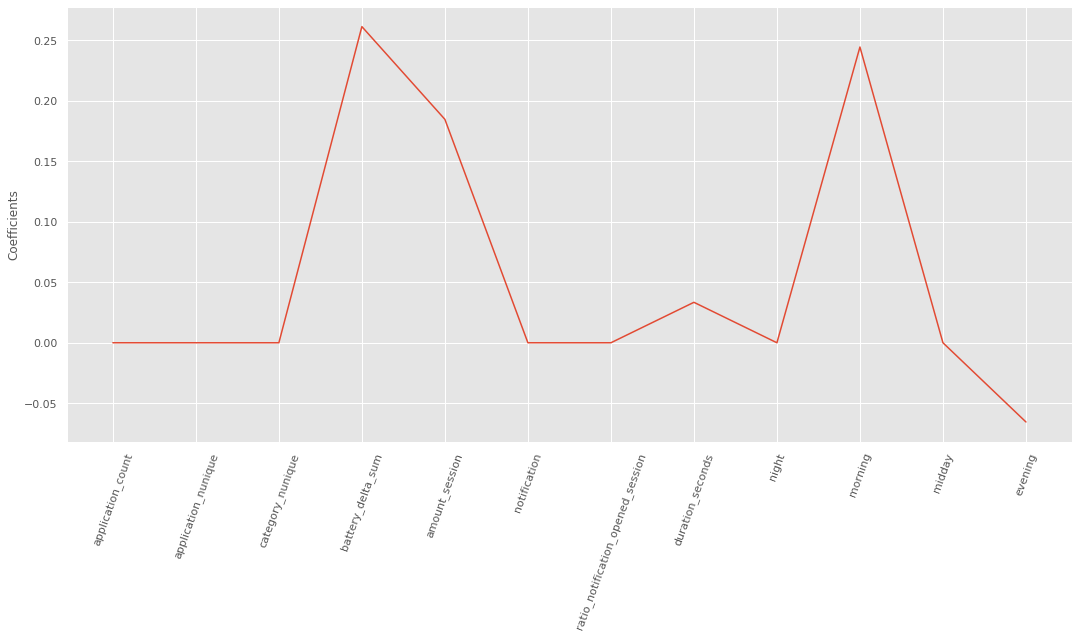

In [0]:
# using lasso for feature selection
names = df[[u'application_count', u'application_nunique',
       u'category_nunique', u'battery_delta_sum', u'amount_session',
       u'notification', u'ratio_notification_opened_session',
       u'duration_seconds', u'night', u'morning', u'midday', u'evening']].columns

lasso = Lasso(alpha=0.001)
lasso_coef = lasso.fit(X_scaled, Y).coef_

plt.figure(figsize=(18,8))
_ = plt.plot(range(len(names)), lasso_coef) 
_ = plt.xticks(range(len(names)), names, rotation=70) 
_ = plt.ylabel('Coefficients') 
plt.show()

As Lasso zero down all unimportant features, we can see from above graph that 'application_nunique', 'battery_delta_sum', 'amount_session', 'ratio_notification_opened_session', 'duration_seconds', 'night', 'morning' and 'midday' are the most significant feature here. Let us just fit our model on these 8 features.

In [0]:
X_new = np.asarray(df[[u'application_nunique', u'battery_delta_sum', u'amount_session',
       u'ratio_notification_opened_session', u'duration_seconds', u'night', u'morning', u'midday']].dropna())
X_new = scale(X_new, with_mean=False)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_new, Y, test_size=0.15, random_state=5)
svc = SVC(random_state=5)
svc.fit(Xtrain, Ytrain)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=5,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
#printing accuracy over 20% test set
y_pred = svc.predict(Xtest)
print ("Accuracy with best features: ", accuracy_score(y_pred, Ytest))

Accuracy with best features:  0.6309523809523809


The accuracy of our model is 63%. But our dataset was imbalanced. So accuracy is not the right evaluation metric and it is better to evaluate on the basis of precision, recall and f1-score.

In [0]:
print (classification_report(Ytest, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.93      0.76       215
           1       0.45      0.11      0.17       121

    accuracy                           0.63       336
   macro avg       0.55      0.52      0.47       336
weighted avg       0.58      0.63      0.55       336



f1-score is 0.55. Not bad at all, considering we have not tuned a single parameter. Now lets just do some parameter tuning and see whether f1-score increases or decreases.

In [0]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['poly']} 

In [0]:
# applying fit/predict functions
svc_grid = GridSearchCV(SVC(random_state=5, max_iter=950), param_grid, refit = True, verbose = 3, n_jobs=-1)
svc_grid.fit(Xtrain, Ytrain)
y_pred = svc_grid.predict(Xtest)

print ("Best Parameters: ", svc_grid.best_params_)

# evaluating predictions using different metrics
print ("\nAccuracy: ", accuracy_score(y_pred, Ytest))
print ("Classification Report (Precision, Recall, F1-Score)")
print (classification_report(Ytest, y_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best Parameters:  {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}

Accuracy:  0.6190476190476191
Classification Report (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

           0       0.66      0.83      0.74       215
           1       0.45      0.25      0.32       121

    accuracy                           0.62       336
   macro avg       0.55      0.54      0.53       336
weighted avg       0.58      0.62      0.59       336



[Parallel(n_jobs=-1)]: Done  24 out of  27 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.4s finished


<p>After parameter tuning, there is significant improvement in both recall and f1-score. Since we knew that the data is not linearly separable, non-linear kernel does the trick here 0.59 F1-Score.</p>
But look at precision and recall of class 1, it is still low. As we have seen that our dataset was imbalanced, now we will try two different oversampling techniques on best selected features and see how it effects our results.

In [0]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

In [0]:
sos = SMOTE(random_state=12)
X_resampled_smote, y_resampled_smote = sos.fit_sample(X_new, Y)

In [0]:
print('Resampled dataset shape %s' % Counter(y_resampled_smote))

Resampled dataset shape Counter({1: 1385, 0: 1385})


In [0]:
# Now split data using all features and repeat above process
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.2, random_state=5)

# applying fit/predict functions
svc_grid_smote = GridSearchCV(SVC(random_state=5, max_iter=1250), param_grid, refit = True, verbose = 3, n_jobs=-1)
svc_grid_smote.fit(Xtrain, Ytrain)
y_pred = svc_grid_smote.predict(Xtest)

# evaluating predictions using different metrics
print ("Accuracy: ", accuracy_score(y_pred, Ytest))
print ("Classification Report (Precision, Recall, F1-Score)")
print (classification_report(Ytest, y_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy:  0.6010830324909747
Classification Report (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

           0       0.56      0.78      0.65       268
           1       0.68      0.44      0.53       286

    accuracy                           0.60       554
   macro avg       0.62      0.61      0.59       554
weighted avg       0.62      0.60      0.59       554



[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.4s finished


In [0]:
ros = RandomOverSampler(random_state=12)
X_resampled_over, y_resampled_over = ros.fit_sample(X_new, Y)

In [0]:
print('Resampled dataset shape %s' % Counter(y_resampled_over))

Resampled dataset shape Counter({1: 1385, 0: 1385})


In [0]:
# Now split data using all features and repeat above process
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resampled_over, y_resampled_over, test_size=0.2, random_state=5)

# applying fit/predict functions
svc_grid_ros = GridSearchCV(SVC(random_state=5, max_iter=5000), param_grid, refit = True, verbose = 3, n_jobs=-1)
svc_grid_ros.fit(Xtrain, Ytrain)
y_pred = svc_grid_ros.predict(Xtest)

# evaluating predictions using different metrics
print ("Accuracy: ", accuracy_score(y_pred, Ytest))
print ("Classification Report (Precision, Recall, F1-Score)")
print (classification_report(Ytest, y_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    3.1s finished


Accuracy:  0.6371841155234657
Classification Report (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

           0       0.59      0.78      0.68       268
           1       0.71      0.50      0.59       286

    accuracy                           0.64       554
   macro avg       0.65      0.64      0.63       554
weighted avg       0.66      0.64      0.63       554



Plotting ROC Curve

In [0]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Ytest))]
# predict probabilities
lr_probs = svc_grid_ros.predict_proba(Xtest)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Ytest, ns_probs)
lr_auc = roc_auc_score(Ytest, lr_probs)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Ytest, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

AttributeError: ignored

Both f1-score and accuracy now seems to be more balanced. There is noteworthy improvement in precision and recall of class 1. Random oversampling performs significantly better than SMOTE. Now lets try undersampling.

In [0]:
from imblearn.under_sampling import RandomUnderSampler

In [0]:
rus = RandomUnderSampler(random_state=12)
X_resampled_under, y_resampled_under = rus.fit_sample(X_new, Y)

In [0]:
print('Resampled dataset shape %s' % Counter(y_resampled_under))

Resampled dataset shape Counter({0: 852, 1: 852})


In [0]:
# Now split data using all features and repeat above process
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=5)

# applying fit/predict functions
svc_grid_rus = GridSearchCV(SVC(random_state=5, max_iter=5000), param_grid, refit = True, verbose = 3, n_jobs=-1)
svc_grid_rus.fit(Xtrain, Ytrain)
y_pred = svc_grid_rus.predict(Xtest)

# evaluating predictions using different metrics
print ("Accuracy: ", accuracy_score(y_pred, Ytest))
print ("Classification Report (Precision, Recall, F1-Score)")
print (classification_report(Ytest, y_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    3.2s finished


Accuracy:  0.6173285198555957
Classification Report (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

           0       0.60      0.64      0.62       268
           1       0.64      0.60      0.62       286

    accuracy                           0.62       554
   macro avg       0.62      0.62      0.62       554
weighted avg       0.62      0.62      0.62       554



<b>Conclusion: </b>Oversampling yields better results than undersampling.

Finally, lets visualize the our data distribution and decision boundary of our best performing model for better understanding.

In [0]:
X_new = np.asarray(df[[u'duration_seconds', u'midday']].dropna())
X_new = scale(X_new, with_mean=False)

ros = RandomOverSampler(random_state=12)
X_resampled, y_resampled = ros.fit_sample(X_new, Y)

Data distribution can be seen below. Looks quite overlapped.

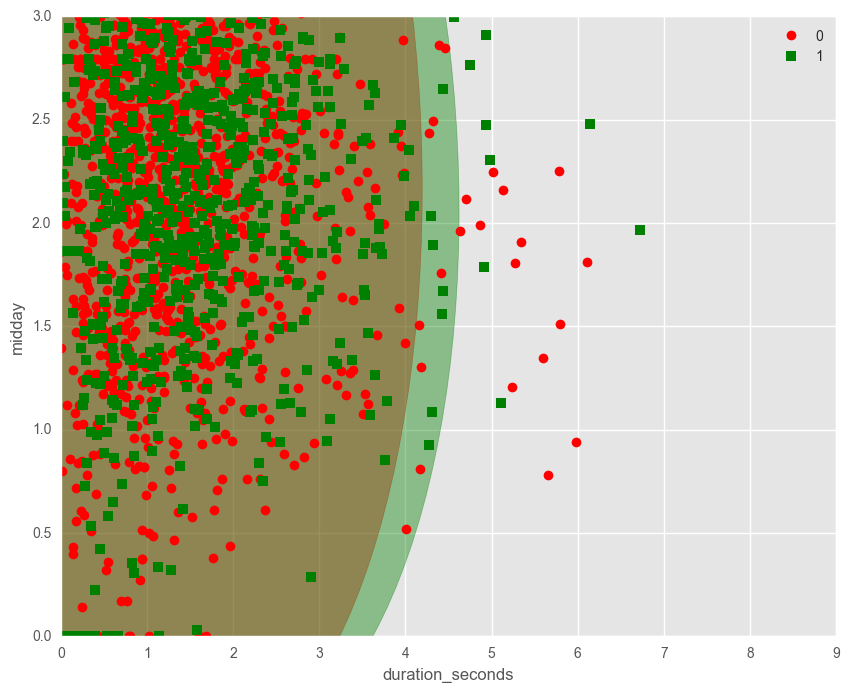

In [0]:
t.plotCov(X_new, Y, labels=[u'duration_seconds', u'midday'])

In [0]:
# Now split data using all features and repeat above process
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=5)

# applying fit/predict functions
svc_grid_ros = GridSearchCV(SVC(random_state=5, max_iter=5000), param_grid, refit = True, verbose = 3, n_jobs=-1)
svc_grid_ros.fit(Xtrain, Ytrain)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    3.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=5000,
                           probability=False, random_state=5, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

Decision boundaries of trained model can be viewed below. Its is evident that the data is too overlapped and not linearly separable.

C:\Program Files\Anaconda2\lib\site-packages\matplotlib\contour.py:1472: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
C:\Program Files\Anaconda2\lib\site-packages\matplotlib\contour.py:1473: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
C:\Program Files\Anaconda2\lib\site-packages\matplotlib\contour.py:1474: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  y0 = ma.minimum(y)
C:\Program Files\Anaconda2\lib\site-packages\matplotlib\contour.py:1475: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  y1 = ma.maximum(y)


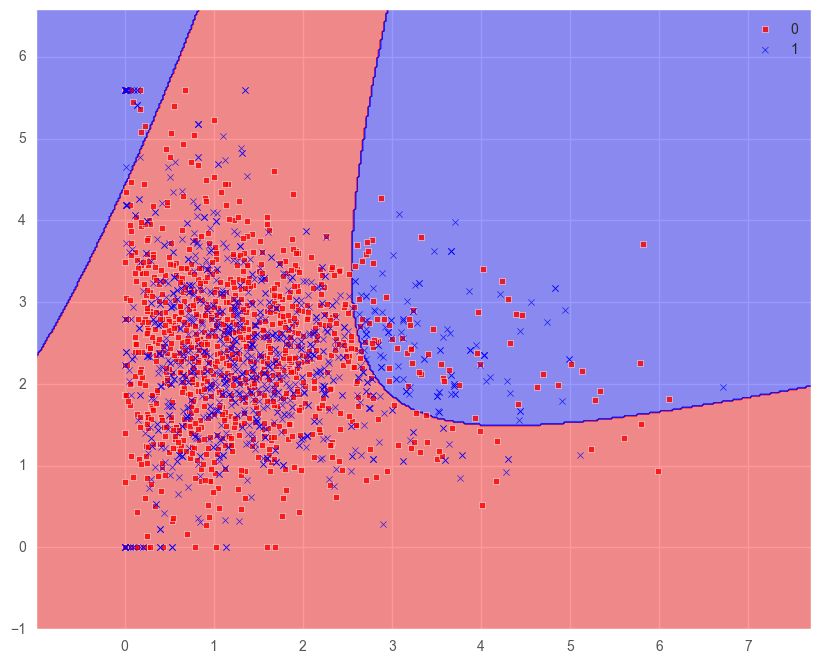

In [0]:
t.plot_decision_regions(Xtrain, Ytrain, clf=svc_grid_ros, res=0.02, cycle_marker=True, legend=1)

## Saving Best Model

In [0]:
joblib.dump(svc_grid_ros, 'SVM.joblib')

['SVM.joblib']

In [1]:
joblib.load

NameError: ignored